In [29]:
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')
import shap
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
from utils import readJSON, preprocess
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from loguru import logger
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
import pandas as pd

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif

print(f'{datetime.today()}')

2022-07-16 14:11:35.086515


In [30]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
logger_id = logger.add('./log/1_other_{time}.log', rotation='1 week')
print(f'{datetime.now()}')

2022-07-16 14:11:37.211515


In [32]:
# 数据平衡使用的方法
USE_randomDownSample = True
USE_Tomek_links = True

USE_ADASYN = True
USE_randomOverSample = True
USE_SMOTE = True

USE_SMOTETomek = False

# 特征选择
USE_chi2 = False
USE_f_classif = True
USE_mutual_info_classif = True

In [36]:
xinzongbiao = pd.read_excel('./input/心总表.xlsx', sheet_name='总表')
xinzongbiao

,证名,病案号,性别,年龄,S1,S2,S3,S4,S5,S6,...,S116,S117,S118,S119,S120,S121,S122,S123,S124,S125
0,4.0,NaN,1.0,31.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,NaN,1.0,93.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,NaN,1.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.0,NaN,1.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.0,NaN,1.0,37.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,4.0,152769.0,1.0,71.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
1739,3.0,130013.0,2.0,70.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
1740,4.0,176082.0,1.0,73.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
1741,NaN,NaN,NaN,NaN,5.000000,9.000000,18.000000,8.000000,8.000000,4.000000,...,696.00000,147.000000,140.000000,193.000000,146.00000,15.000000,50.000000,260.000000,788.000000,100.000000


In [37]:
xinzongbiao.drop(columns=['病案号', '性别', '年龄'], inplace=True)
xinzongbiao.dropna(inplace=True)
xinzongbiao.astype(int)
id2feature = readJSON('./input/id2feature.json')
xinzongbiao = xinzongbiao.rename(columns=id2feature)
xinzongbiao['证名'].value_counts()

1.0    621
5.0    548
3.0    184
4.0    121
7.0    112
2.0     70
6.0     53
8.0     32
Name: 证名, dtype: int64

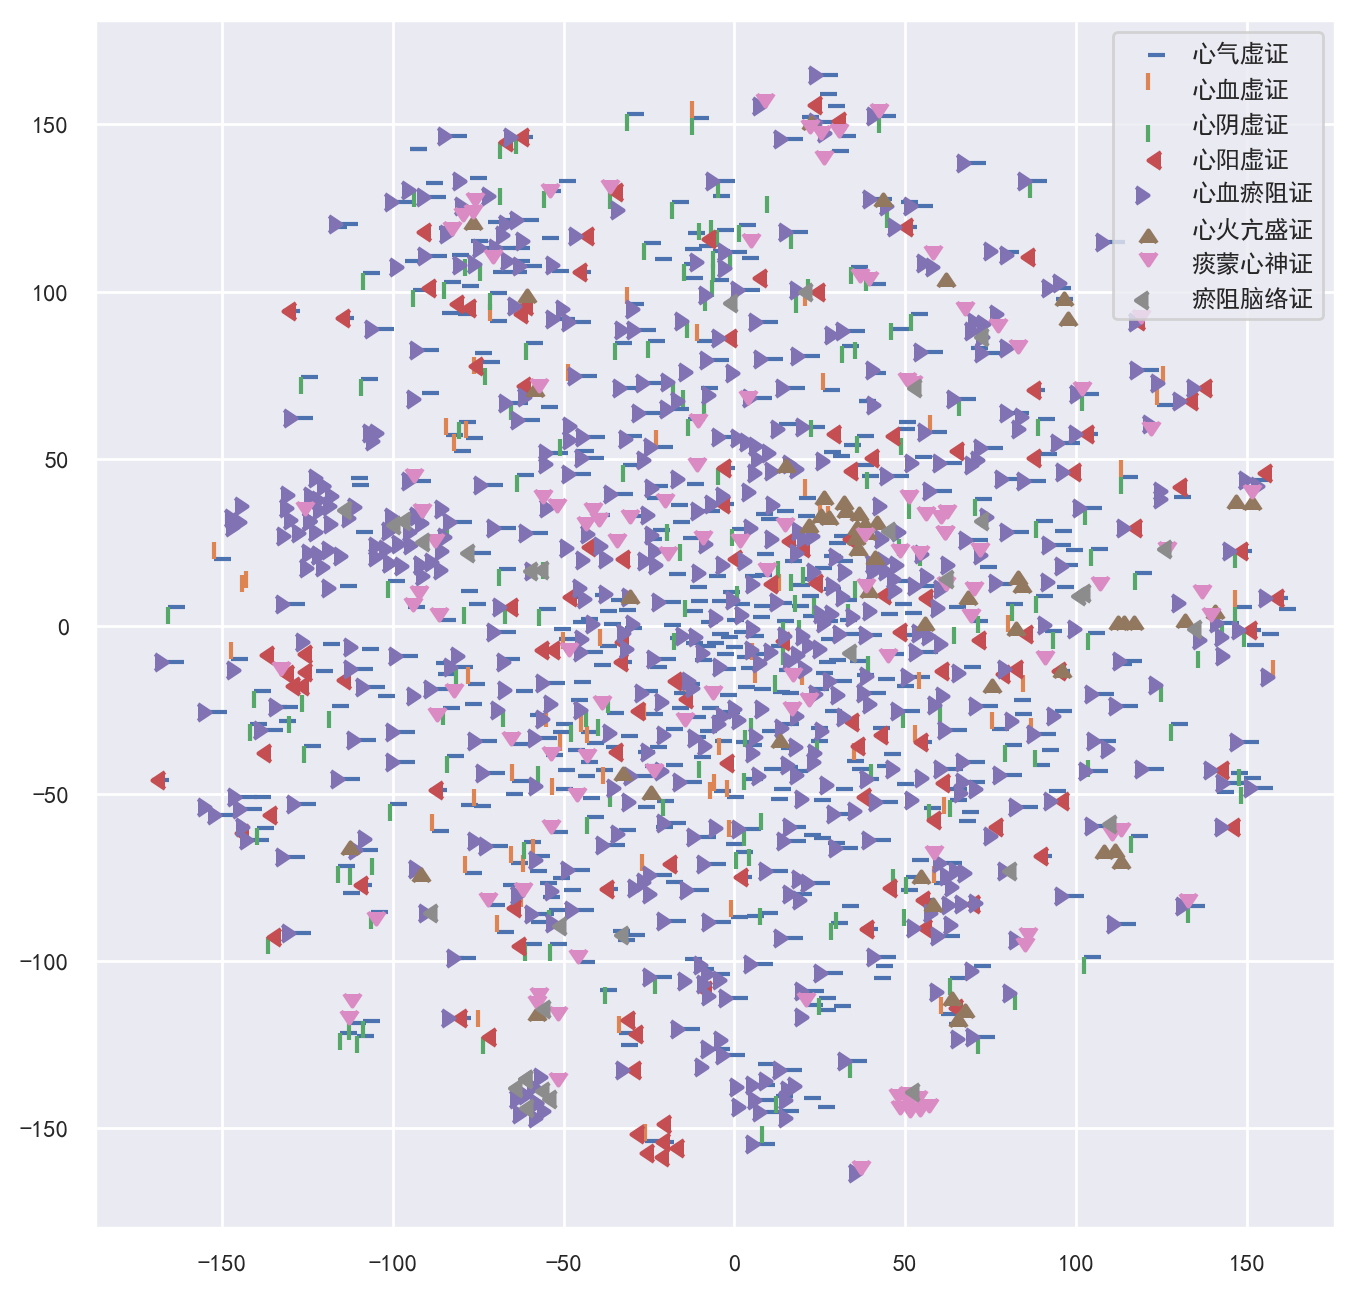

In [41]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
zhenghou2id = readJSON('./input/zhenghou2id.json')
X, y = preprocess(path='./input/心总表.xlsx', sheet_name='总表')
scaler = StandardScaler()
X = xinzongbiao.drop(columns='证名')
y = xinzongbiao['证名']
X = scaler.fit_transform(X)
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(8,8),dpi=200)
for i in range(1,9):
    plt.scatter(X_tsne[y==i][:,0],X_tsne[y==i][:,1],cmap=plt.cm.Set3(i),marker=i,label=zhenghou2id[str(i)])
plt.legend()
# plt.savefig('1.png')

In [12]:
# 心总表总共出现的症状频数
xinzongbiao.drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)

薄     968.0
胸闷    854.0
心悸    804.0
脉弦    788.0
白     771.0
      ...  
点刺      0.0
舌衄      0.0
老       0.0
枯       0.0
荣       0.0
Length: 125, dtype: float64

In [13]:
# 1.心气虚症状统计
c1 = xinzongbiao[xinzongbiao['证名'] == 1].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c1, np.round(c1 / xinzongbiao['证名'].value_counts()[1], 2)])

,薄,胸闷,心悸,脉细,白,乏力,脉弦,胸部闷痛,失眠,神疲,...,癫,肿胀,瘦薄,点刺,昏迷,咯血,强硬,谵语,短缩,颤动
0,378.00,340.00,340.00,291.00,285.00,265.00,256.00,239.00,223.00,215.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.61,0.55,0.55,0.47,0.46,0.43,0.41,0.38,0.36,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# 2.心血虚证
c2 = xinzongbiao[xinzongbiao['证名'] == 2].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c2, np.round(c2 / xinzongbiao['证名'].value_counts()[2], 2)])

,薄,脉细,白,心悸,乏力,失眠,头晕,神疲,淡红,脉弦,...,青,咯痰,荣,枯,老,嫩,喉中痰鸣,齿痕,肿胀,五心烦热
0,52.00,44.00,42.0,37.00,36.00,32.00,30.00,28.0,28.0,24.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.74,0.63,0.6,0.53,0.51,0.46,0.43,0.4,0.4,0.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# 心阴虚证
c3 = xinzongbiao[xinzongbiao['证名'] == 3].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c3, np.round(c3 / xinzongbiao['证名'].value_counts()[3], 2)])

,胸闷,心悸,薄,脉细,红,脉弦,乏力,失眠,白,神疲,...,荣,枯,老,嫩,咯血,肿胀,无汗,喉中痰鸣,怔忡,面色淡白
0,118.00,103.00,89.00,86.00,84.00,80.00,74.0,69.00,67.00,61.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.64,0.56,0.48,0.47,0.46,0.43,0.4,0.38,0.36,0.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# 心阳虚证
c4 = xinzongbiao[xinzongbiao['证名'] == 4].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c4, np.round(c4 / xinzongbiao['证名'].value_counts()[4], 2)])

,心悸,薄,胸闷,白,腻,气喘,乏力,脉细,下肢浮肿,失眠,...,口舌生疮,舌衄,语骞,失语,绛,尖红,荣,枯,老,五心烦热
0,72.0,63.00,63.00,59.00,51.00,47.00,46.00,45.00,44.00,43.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6,0.52,0.52,0.49,0.42,0.39,0.38,0.37,0.36,0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# 心血瘀阻证
c5 = xinzongbiao[xinzongbiao['证名'] == 5].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c5, np.round(c5 / xinzongbiao['证名'].value_counts()[5], 2)])

,薄,脉弦,胸闷,白,胸部闷痛,心悸,腻,红,脉细,乏力,...,点刺,无汗,痿软,强硬,歪斜,颤动,短缩,潮热,痫,五心烦热
0,303.00,286.00,269.00,263.00,203.00,200.00,195.00,185.00,171.00,170.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.55,0.52,0.49,0.48,0.37,0.36,0.36,0.34,0.31,0.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# 心火亢盛证
c6 = xinzongbiao[xinzongbiao['证名'] == 6].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c6, np.round(c6 / xinzongbiao['证名'].value_counts()[6], 2)])

,红,脉弦,黄,薄,失眠,腻,心悸,脉数,白,乏力,...,嗜睡,头部刺痛,痫,狂,痴呆,肢冷,谵语,神昏,健忘,五心烦热
0,44.00,32.0,30.00,28.00,26.00,24.00,17.00,15.00,15.00,11.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.83,0.6,0.57,0.53,0.49,0.45,0.32,0.28,0.28,0.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# 痰蒙心神证
c7 = xinzongbiao[xinzongbiao['证名'] == 7].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c7, np.round(c7 / xinzongbiao['证名'].value_counts()[7], 2)])

,腻,脉弦,红,黄,薄,头晕,脉细,脉滑,心悸,神疲,...,咯血,荣,枯,老,嫩,血痰,瘦薄,点刺,怔忡,肿胀
0,66.00,60.00,55.00,44.00,44.00,42.00,40.00,35.00,35.00,33.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.59,0.54,0.49,0.39,0.39,0.38,0.36,0.31,0.31,0.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# 痰阻脑络证
c8 = xinzongbiao[xinzongbiao['证名'] == 8].drop(columns='证名').reset_index(drop=True).sum().sort_values(ascending=False)
pd.DataFrame(data=[c8, np.round(c8 / xinzongbiao['证名'].value_counts()[8], 2)])

,脉弦,腻,薄,红,脉细,紫暗,黄,头部刺痛,乏力,神疲,...,恶寒,狂,痴呆,肢冷,谵语,嗜睡,多梦,少气懒言,咯血,脉缓
0,14.00,13.00,11.00,10.00,9.00,9.00,9.00,8.00,8.00,8.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.44,0.41,0.34,0.31,0.28,0.28,0.28,0.25,0.25,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X, y = preprocess(path='./input/心总表.xlsx', sheet_name='总表')
X.columns = id2feature.values()
if USE_chi2:
    print('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    print('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    print('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())

使用 F检验 进行特征筛选


In [76]:
X

,面色恍白,面色萎黄,面色红赤,两颧潮红,口唇指甲紫绀,面部浮肿,下肢浮肿,全身浮肿,胸部闷痛,胸部刺痛,...,脉弱,脉细,脉结,脉代,脉数,脉沉,脉涩,脉滑,脉弦,脉缓
0,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1736,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1737,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [77]:
zhenghou2id = readJSON('./input/zhenghou2id.json')
id2feature = readJSON('./input/id2feature.json')
N = 15
Accuracy = []
Precision = []
Recall = []
F1 = []
le = LabelEncoder()
y = le.fit_transform(y)
print(f'{datetime.now()}')

2022-07-13 15:57:27.077453


  0%|          | 0/8 [00:00<?, ?it/s]

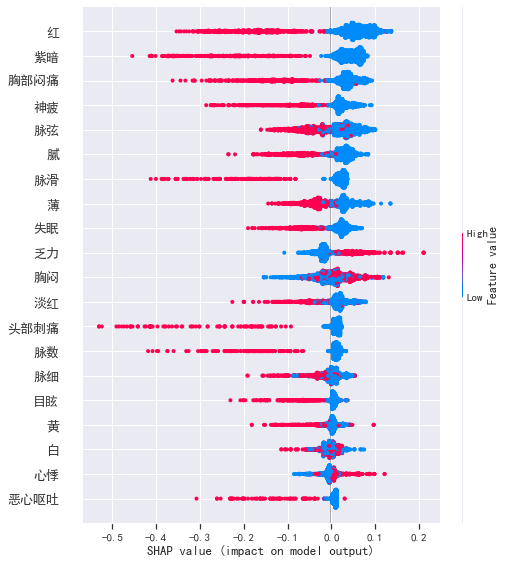

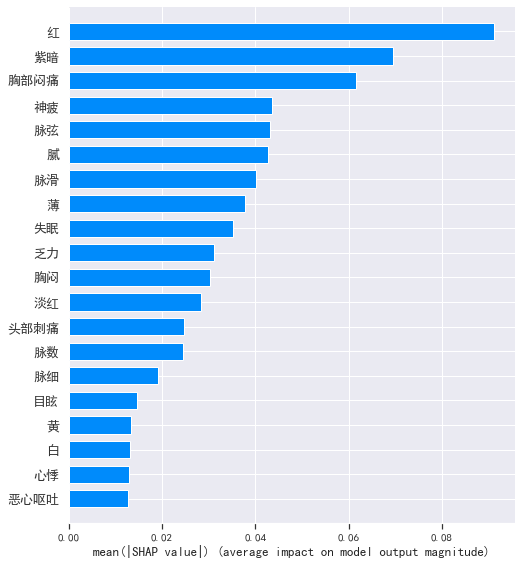

2022-07-13 19:00:18.115 | DEBUG    | __main__:<cell line: 1>:108 - 心气虚证	0.799	0.777	0.839	0.807
2022-07-13 19:00:18.117 | DEBUG    | __main__:<cell line: 1>:110 - weight	['胸闷', '薄', '失眠', '红', '胸部闷痛', '白', '脉弦', '动则尤甚', '紫暗', '脉细', '神疲', '淡红', '心悸', '纳呆', '黄', '乏力', '头晕', '下肢浮肿', '目眩', '脉沉', '气短', '脉数', '腻', '脉结', '头部刺痛', '恶心呕吐', '脉滑', '气喘', '咳嗽', '口唇指甲紫绀', '不能平卧', '口渴欲饮', '脉弱', '脉缓', '心烦', '畏寒', '自汗', '淡白', '裂纹', '胸部刺痛', '心胸窒闷', '白痰', '厚', '面部浮肿', '少气懒言', '多梦', '烦躁', '发热', '齿痕', '少', '脉代', '脉涩', '全身浮肿', '胸部胀痛', '神昏', '昏迷', '面色红赤', '心前区绞痛', '喉中痰鸣', '健忘', '痫', '腹胀', '五心烦热', '尿赤', '语骞', '剥落']
2022-07-13 19:00:18.118 | DEBUG    | __main__:<cell line: 1>:111 - gain	['脉滑', '头部刺痛', '紫暗', '红', '昏迷', '神昏', '神疲', '胸部闷痛', '脉数', '胸部胀痛', '齿痕', '厚', '气喘', '腻', '少', '喉中痰鸣', '裂纹', '脉弱', '脉细', '黄', '多梦', '全身浮肿', '脉结', '目眩', '恶心呕吐', '腹胀', '脉缓', '头晕', '淡红', '口唇指甲紫绀', '畏寒', '胸闷', '乏力', '自汗', '少气懒言', '心胸窒闷', '白痰', '失眠', '薄', '脉沉', '纳呆', '胸部刺痛', '淡白', '脉涩', '发热', '脉弦', '口渴欲饮', '烦躁', '咳嗽', '心悸', '动则尤甚', '白'

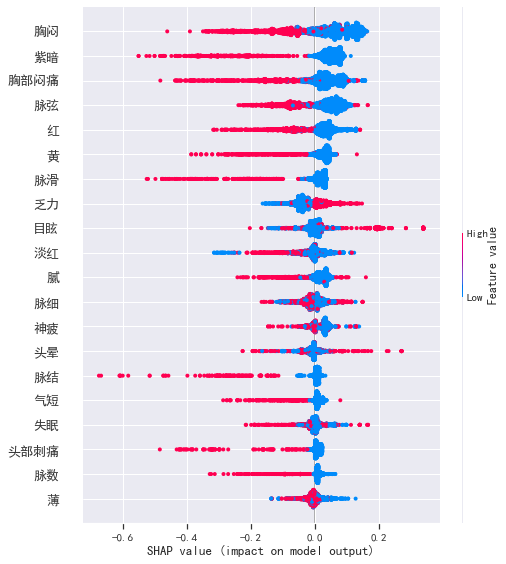

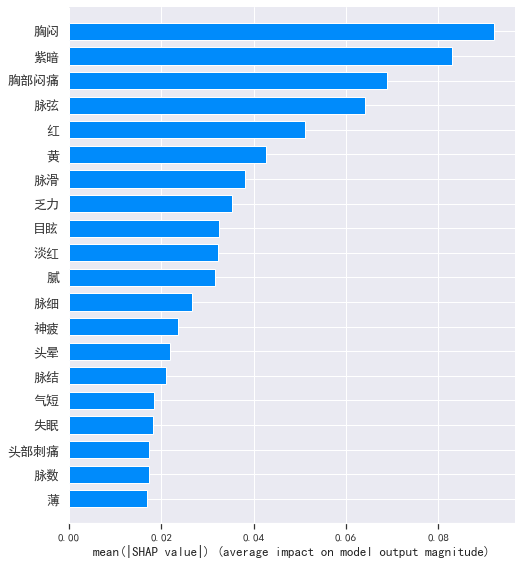

2022-07-13 19:00:23.777 | DEBUG    | __main__:<cell line: 1>:108 - 心血虚证	0.94	0.902	0.988	0.943
2022-07-13 19:00:23.779 | DEBUG    | __main__:<cell line: 1>:110 - weight	['胸部闷痛', '脉细', '纳呆', '白', '心悸', '气喘', '紫暗', '胸闷', '头晕', '薄', '淡红', '失眠', '乏力', '腻', '目眩', '红', '脉滑', '神疲', '脉弦', '气短', '咳嗽', '脉数', '动则尤甚', '脉弱', '脉结', '淡白', '黄', '头部刺痛', '口渴欲饮', '自汗', '口唇指甲紫绀', '下肢浮肿', '不能平卧', '恶心呕吐', '发热', '裂纹', '脉缓', '烦躁', '脉沉', '心烦', '少', '多梦', '神昏', '昏迷', '畏寒', '脉代', '全身浮肿', '胸部刺痛', '腹胀', '五心烦热', '口咽干燥', '齿痕', '心前区绞痛', '胸部胀痛', '喉中痰鸣', '白痰', '少气懒言', '癫', '痫', '厚', '润', '脉涩']
2022-07-13 19:00:23.780 | DEBUG    | __main__:<cell line: 1>:111 - gain	['头部刺痛', '紫暗', '脉滑', '神昏', '目眩', '胸闷', '脉代', '脉沉', '多梦', '淡红', '脉结', '黄', '腹胀', '动则尤甚', '五心烦热', '胸部闷痛', '恶心呕吐', '红', '胸部刺痛', '裂纹', '头晕', '气喘', '口渴欲饮', '失眠', '脉弦', '发热', '脉细', '脉弱', '自汗', '癫', '脉数', '口唇指甲紫绀', '气短', '脉缓', '咳嗽', '纳呆', '乏力', '下肢浮肿', '腻', '少', '薄', '烦躁', '胸部胀痛', '神疲', '白', '口咽干燥', '心悸', '畏寒', '淡白', '心前区绞痛', '痫', '润', '脉涩', '昏迷', '心烦', '齿痕', '全身浮肿'

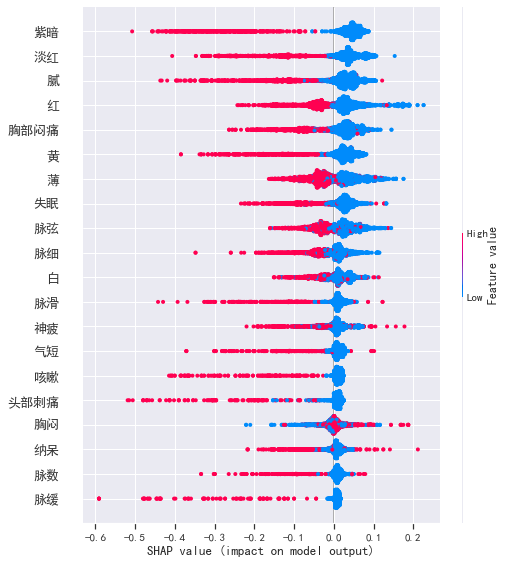

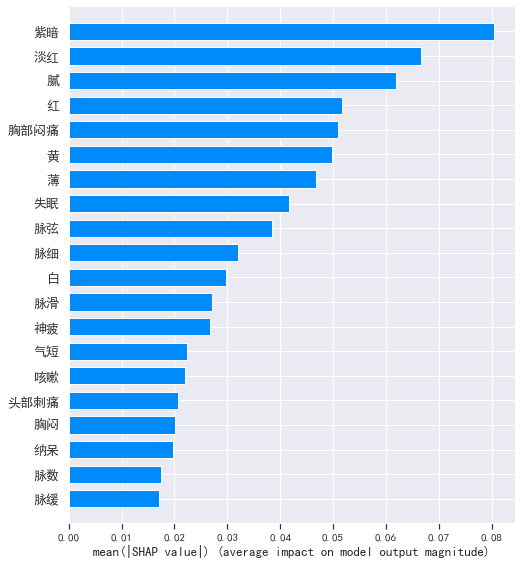

2022-07-13 19:00:30.003 | DEBUG    | __main__:<cell line: 1>:108 - 心阴虚证	0.824	0.764	0.936	0.841
2022-07-13 19:00:30.004 | DEBUG    | __main__:<cell line: 1>:110 - weight	['心悸', '胸闷', '脉细', '胸部闷痛', '薄', '头晕', '腻', '神疲', '纳呆', '失眠', '黄', '白', '淡红', '脉弦', '红', '气喘', '紫暗', '气短', '动则尤甚', '下肢浮肿', '目眩', '乏力', '脉数', '脉滑', '口渴欲饮', '脉结', '脉代', '咳嗽', '头部刺痛', '脉沉', '心胸窒闷', '淡白', '少', '脉弱', '脉缓', '恶心呕吐', '胸部刺痛', '心烦', '齿痕', '白痰', '自汗', '口咽干燥', '裂纹', '厚', '口唇指甲紫绀', '不能平卧', '烦躁', '畏寒', '脉涩', '胸部胀痛', '神昏', '腹胀', '发热', '多梦', '健忘', '癫', '痫', '语骞', '面色萎黄', '面部浮肿', '全身浮肿', '胸部剧痛', '少气懒言', '昏迷', '五心烦热', '尿赤', '瘦薄', '短缩', '剥落']
2022-07-13 19:00:30.006 | DEBUG    | __main__:<cell line: 1>:111 - gain	['紫暗', '头部刺痛', '咳嗽', '脉滑', '淡白', '黄', '红', '脉缓', '淡红', '恶心呕吐', '自汗', '腻', '脉代', '气短', '腹胀', '厚', '脉涩', '心胸窒闷', '脉沉', '脉数', '脉弱', '少', '胸部闷痛', '心烦', '神疲', '畏寒', '脉结', '神昏', '纳呆', '胸闷', '胸部刺痛', '烦躁', '脉细', '失眠', '口唇指甲紫绀', '多梦', '少气懒言', '脉弦', '齿痕', '不能平卧', '目眩', '薄', '下肢浮肿', '癫', '昏迷', '语骞', '动则尤甚', '口咽干燥', '气喘', '口

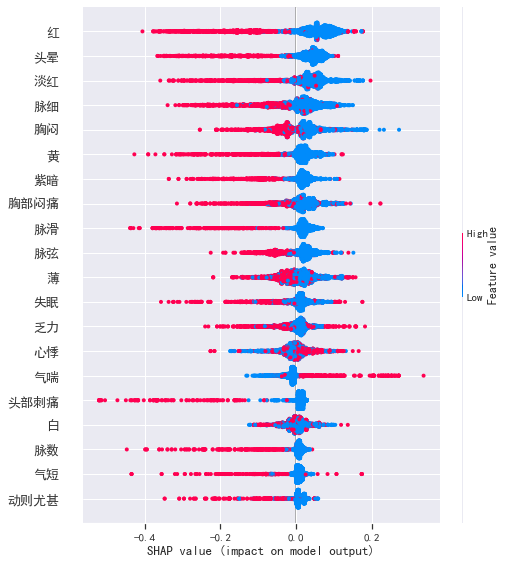

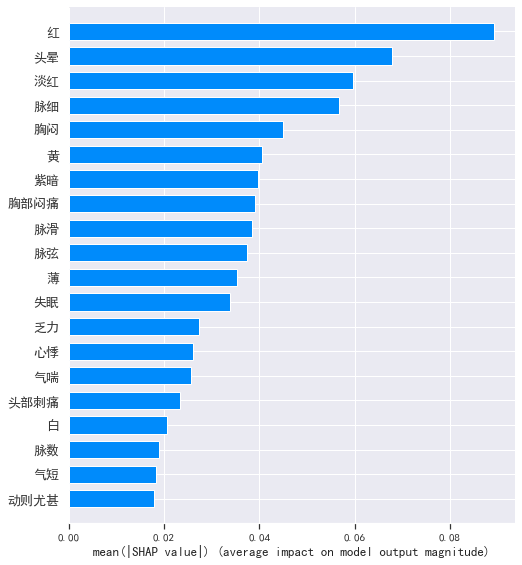

2022-07-13 19:00:36.450 | DEBUG    | __main__:<cell line: 1>:108 - 心阳虚证	0.895	0.86	0.944	0.9
2022-07-13 19:00:36.451 | DEBUG    | __main__:<cell line: 1>:110 - weight	['心悸', '胸闷', '脉细', '胸部闷痛', '白', '神疲', '腻', '纳呆', '黄', '脉滑', '失眠', '紫暗', '下肢浮肿', '气喘', '气短', '乏力', '红', '薄', '动则尤甚', '淡红', '口唇指甲紫绀', '咳嗽', '头晕', '目眩', '脉弦', '脉结', '脉数', '头部刺痛', '少', '齿痕', '自汗', '口渴欲饮', '脉弱', '脉缓', '心胸窒闷', '不能平卧', '多梦', '脉沉', '脉涩', '烦躁', '淡白', '面色恍白', '神昏', '畏寒', '面色萎黄', '胸部刺痛', '心前区绞痛', '白痰', '少气懒言', '恶心呕吐', '腹胀', '裂纹', '短缩', '脉代', '胸部胀痛', '心烦', '厚', '润', '面色红赤', '面部浮肿', '全身浮肿', '昏迷', '痫', '发热', '五心烦热', '瘦薄', '胸部剧痛', '喉中痰鸣', '健忘', '癫', '无汗', '语骞', '剥落']
2022-07-13 19:00:36.452 | DEBUG    | __main__:<cell line: 1>:111 - gain	['头部刺痛', '头晕', '脉涩', '红', '淡红', '喉中痰鸣', '脉代', '恶心呕吐', '不能平卧', '口渴欲饮', '目眩', '黄', '胸部胀痛', '厚', '自汗', '失眠', '动则尤甚', '脉数', '脉滑', '淡白', '紫暗', '癫', '气短', '心前区绞痛', '胸部闷痛', '脉沉', '脉细', '气喘', '脉缓', '神昏', '下肢浮肿', '纳呆', '全身浮肿', '脉弱', '胸部刺痛', '腹胀', '痫', '脉结', '咳嗽', '发热', '多梦', '胸闷', '薄', '语骞', '裂纹

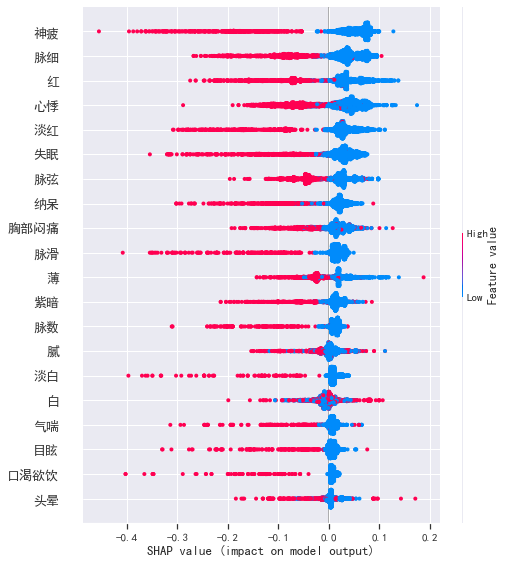

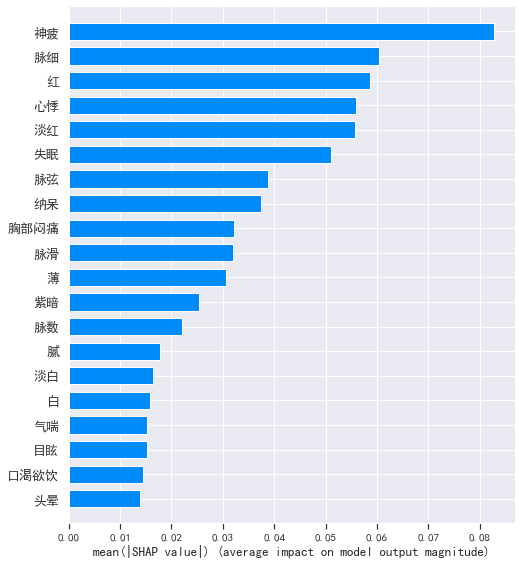

2022-07-13 19:00:42.024 | DEBUG    | __main__:<cell line: 1>:108 - 心血瘀阻证	0.883	0.871	0.9	0.885
2022-07-13 19:00:42.025 | DEBUG    | __main__:<cell line: 1>:110 - weight	['胸部闷痛', '红', '失眠', '心悸', '神疲', '白', '脉细', '薄', '下肢浮肿', '胸闷', '黄', '腻', '脉沉', '气喘', '淡红', '乏力', '目眩', '气短', '纳呆', '动则尤甚', '头晕', '脉弱', '脉滑', '脉弦', '口唇指甲紫绀', '胸部刺痛', '头部刺痛', '淡白', '脉结', '脉数', '咳嗽', '自汗', '紫暗', '多梦', '口渴欲饮', '脉代', '脉缓', '面部浮肿', '心前区绞痛', '心烦', '不能平卧', '白痰', '少气懒言', '恶心呕吐', '腹胀', '裂纹', '厚', '少', '脉涩', '心胸窒闷', '昏迷', '癫', '五心烦热', '面色恍白', '面色红赤', '全身浮肿', '健忘', '神昏', '烦躁', '痫', '发热', '畏寒', '无汗', '口咽干燥', '尿赤', '语骞', '齿痕', '瘦薄', '短缩', '剥落']
2022-07-13 19:00:42.026 | DEBUG    | __main__:<cell line: 1>:111 - gain	['神疲', '脉代', '脉滑', '失眠', '淡红', '淡白', '纳呆', '短缩', '癫', '脉数', '腻', '口渴欲饮', '昏迷', '脉细', '紫暗', '红', '神昏', '头晕', '不能平卧', '痫', '头部刺痛', '烦躁', '气喘', '畏寒', '心悸', '脉弦', '目眩', '白', '脉缓', '脉结', '动则尤甚', '白痰', '厚', '心前区绞痛', '口唇指甲紫绀', '胸部闷痛', '健忘', '尿赤', '气短', '少', '发热', '胸部刺痛', '脉沉', '脉弱', '心胸窒闷', '薄', '多梦', '咳嗽', '脉涩', 

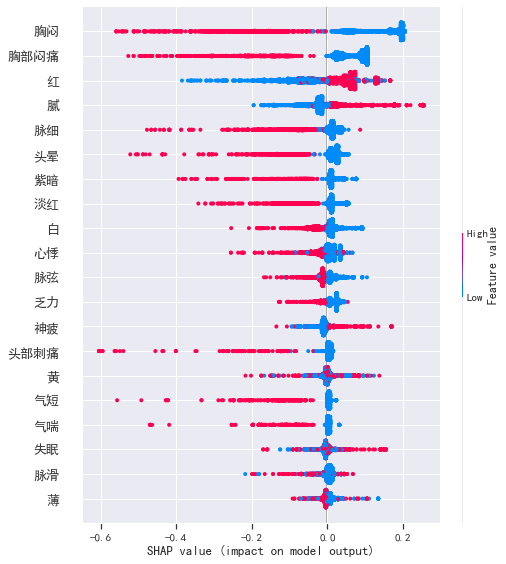

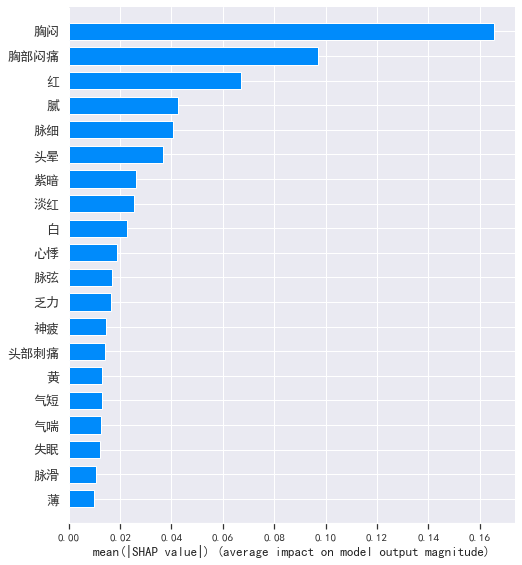

2022-07-13 19:00:47.527 | DEBUG    | __main__:<cell line: 1>:108 - 心火亢盛证	0.991	0.983	1.0	0.991
2022-07-13 19:00:47.529 | DEBUG    | __main__:<cell line: 1>:110 - weight	['心悸', '红', '黄', '腻', '胸闷', '失眠', '薄', '神疲', '头晕', '白', '脉滑', '脉细', '胸部闷痛', '头部刺痛', '纳呆', '脉弦', '心烦', '淡红', '紫暗', '口渴欲饮', '下肢浮肿', '乏力', '口唇指甲紫绀', '咳嗽', '目眩', '恶心呕吐', '气短', '发热', '脉数', '动则尤甚', '气喘', '淡白', '昏迷', '脉沉', '胸部刺痛', '多梦', '癫', '痫', '腹胀', '自汗', '尿赤', '脉结', '烦躁', '润', '少', '脉缓', '两颧潮红', '面部浮肿', '喉中痰鸣', '白痰', '神昏', '口咽干燥', '裂纹', '短缩', '厚', '脉弱', '面色红赤', '心胸窒闷', '不能平卧', '健忘', '畏寒', '五心烦热', '脉代', '面色萎黄', '胸部剧痛', '心前区绞痛', '无汗', '剥落', '脉涩']
2022-07-13 19:00:47.529 | DEBUG    | __main__:<cell line: 1>:111 - gain	['胸部闷痛', '胸闷', '脉细', '红', '紫暗', '脉沉', '气喘', '淡红', '腻', '脉缓', '头部刺痛', '白', '痫', '头晕', '气短', '烦躁', '神昏', '黄', '五心烦热', '胸部剧痛', '纳呆', '尿赤', '脉弦', '失眠', '动则尤甚', '恶心呕吐', '癫', '脉数', '少', '自汗', '口咽干燥', '咳嗽', '发热', '短缩', '面色红赤', '两颧潮红', '脉滑', '神疲', '淡白', '心悸', '乏力', '脉弱', '口唇指甲紫绀', '白痰', '薄', '口渴欲饮', '心烦', '面色萎黄', '下肢浮肿'

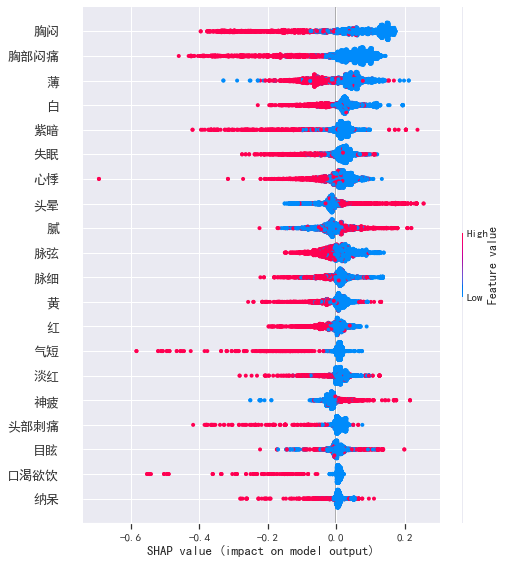

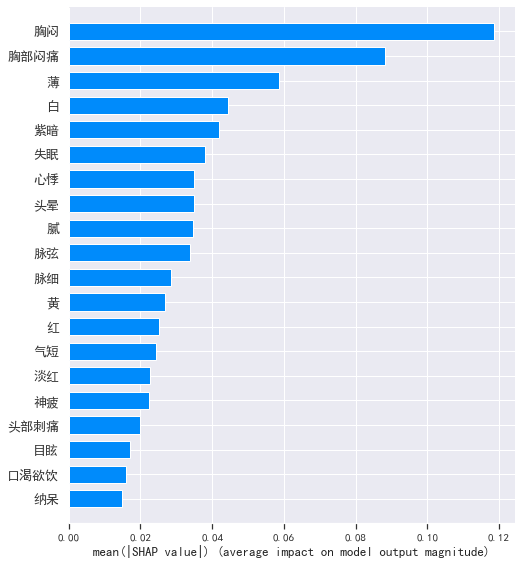

2022-07-13 19:00:53.498 | DEBUG    | __main__:<cell line: 1>:108 - 痰蒙心神证	0.899	0.865	0.945	0.903
2022-07-13 19:00:53.500 | DEBUG    | __main__:<cell line: 1>:110 - weight	['腻', '心悸', '胸部闷痛', '失眠', '紫暗', '胸闷', '脉滑', '神疲', '头晕', '黄', '脉弦', '脉细', '薄', '乏力', '气喘', '淡红', '白', '下肢浮肿', '目眩', '咳嗽', '头部刺痛', '气短', '纳呆', '红', '脉数', '脉沉', '口渴欲饮', '脉缓', '口唇指甲紫绀', '烦躁', '自汗', '厚', '心烦', '神昏', '恶心呕吐', '齿痕', '脉代', '心胸窒闷', '淡白', '动则尤甚', '发热', '裂纹', '脉弱', '脉结', '胸部刺痛', '少', '胸部胀痛', '不能平卧', '昏迷', '畏寒', '五心烦热', '白痰', '多梦', '痫', '腹胀', '脉涩', '面色恍白', '面色红赤', '面部浮肿', '心前区绞痛', '喉中痰鸣', '少气懒言', '健忘', '无汗', '语骞', '短缩', '润']
2022-07-13 19:00:53.500 | DEBUG    | __main__:<cell line: 1>:111 - gain	['胸闷', '发热', '胸部闷痛', '动则尤甚', '无汗', '口渴欲饮', '心烦', '气短', '语骞', '紫暗', '头部刺痛', '头晕', '纳呆', '脉代', '薄', '淡红', '齿痕', '目眩', '昏迷', '脉细', '红', '胸部刺痛', '淡白', '心胸窒闷', '失眠', '自汗', '白痰', '黄', '胸部胀痛', '腻', '脉滑', '脉缓', '气喘', '喉中痰鸣', '白', '腹胀', '少', '健忘', '厚', '脉数', '神疲', '五心烦热', '恶心呕吐', '脉弱', '咳嗽', '面色红赤', '神昏', '脉弦', '下肢浮肿', '心悸', '乏力', 

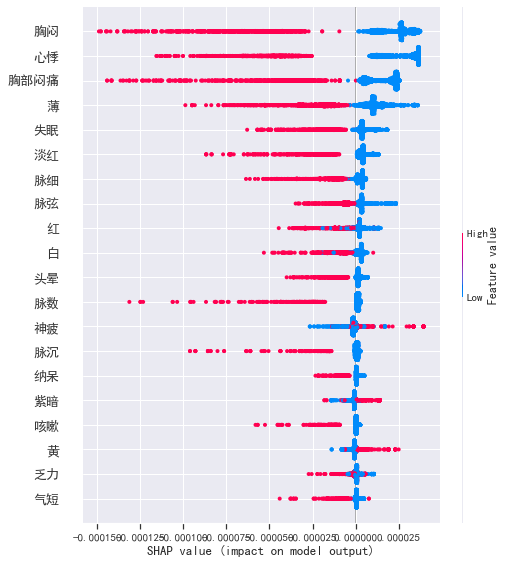

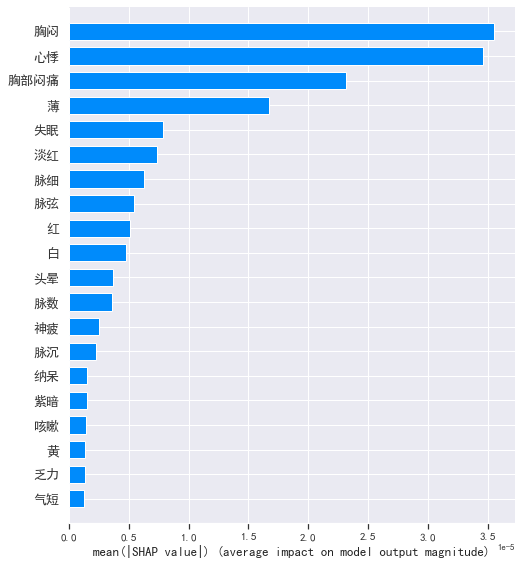

2022-07-13 19:00:59.319 | DEBUG    | __main__:<cell line: 1>:108 - 瘀阻脑络证	0.956	0.924	0.994	0.958
2022-07-13 19:00:59.320 | DEBUG    | __main__:<cell line: 1>:110 - weight	['失眠', '头晕', '薄', '红', '脉细', '神疲', '黄', '头部刺痛', '脉弦', '气短', '淡红', '白', '脉数', '胸部闷痛', '咳嗽', '纳呆', '气喘', '乏力', '紫暗', '脉沉', '胸闷', '腻', '下肢浮肿', '心悸', '胸部胀痛', '动则尤甚', '淡白', '厚', '少', '烦躁', '口渴欲饮', '脉弱', '胸部刺痛', '白痰', '目眩', '瘦薄', '脉滑', '口唇指甲紫绀', '心烦', '心胸窒闷', '不能平卧', '昏迷', '恶心呕吐', '自汗', '齿痕', '脉缓', '胸部剧痛', '痫', '嫩', '脉结']
2022-07-13 19:00:59.321 | DEBUG    | __main__:<cell line: 1>:111 - gain	['心悸', '胸闷', '胸部闷痛', '薄', '淡红', '脉细', '红', '脉数', '脉沉', '齿痕', '白', '厚', '动则尤甚', '脉弦', '失眠', '目眩', '胸部刺痛', '腻', '脉弱', '头部刺痛', '紫暗', '神疲', '心烦', '恶心呕吐', '心胸窒闷', '烦躁', '乏力', '气喘', '纳呆', '咳嗽', '淡白', '头晕', '脉结', '脉缓', '下肢浮肿', '气短', '白痰', '黄', '少', '胸部胀痛', '昏迷', '脉滑', '不能平卧', '痫', '口唇指甲紫绀', '口渴欲饮', '胸部剧痛', '瘦薄', '嫩', '自汗']
2022-07-13 19:00:59.321 | DEBUG    | __main__:<cell line: 1>:112 - cover	['心悸', '胸闷', '胸部闷痛', '齿痕', '动则尤甚', '烦躁', '目眩', '

In [82]:
for i in tqdm(range(8)):
    target = np.where(y == i, 1, 0)
    target = pd.DataFrame(data=target, columns=['证名'])
    X_ = X.copy()
    target_ = target.copy()
    X_.reset_index(drop=True, inplace=True)
    target_.reset_index(drop=True, inplace=True)
    tmp = pd.concat([X_, target_], axis=1)
    tmp1 = tmp[tmp['证名'] == 1][:150]
    # tmp1 = tmp[tmp['证名'] == 1]
    tmp0 = tmp[tmp['证名'] == 0]
    tmp = pd.concat([tmp1, tmp0], axis=0)
    target_ = tmp['证名']
    X_ = tmp.drop(columns=['证名'])
    if USE_SMOTE:
        sample = SMOTE(random_state=64)
    elif USE_SMOTETomek:
        sample = SMOTETomek(random_state=64)
    X_resampled, y_resampled = sample.fit_resample(X_, target_)


    def objective(trial):
        train_x, valid_x, train_y, valid_y = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=7)
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dvalid = xgb.DMatrix(valid_x, label=valid_y)
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'tree_method': 'exact',
            'booster': 'gbtree',
            # 'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.2, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'max_depth': trial.suggest_int("max_depth", 3, 9, step=2),
            'min_child_weight': trial.suggest_int("min_child_weight", 2, 10),
            'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
            'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }
        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        accuracy = accuracy_score(valid_y, preds)
        return accuracy


    study = optuna.create_study(direction="maximize", study_name='xgb_optuna')
    study.optimize(objective, n_trials=100, timeout=600)
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    SHAP_total_topN = {}
    weight_total_topN = {}
    gain_total_topN = {}
    total_gain_total_topN = {}
    total_cover_total_topN = {}
    key = 1
    # fig,ax = plt.subplots(8,1)
    for train_index, test_index in kf.split(X_resampled, y_resampled):
        dtrain = xgb.DMatrix(X_resampled.loc[train_index], label=y_resampled.loc[train_index])
        dvalid = xgb.DMatrix(X_resampled.loc[test_index], label=y_resampled.loc[test_index])
        model = xgb.train(study.best_trial.params, dtrain)
        # xgb.plot_tree(model)
        # plt.subplot(8,1,1)
        # ax = plt.subplot(10,1,key)

        preds = model.predict(dvalid)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        accuracy = accuracy_score(y_resampled.loc[test_index], preds)
        Accuracy.append(accuracy)
        precision = precision_score(y_resampled.loc[test_index], preds)
        Precision.append(precision)
        recall = recall_score(y_resampled.loc[test_index], preds)
        Recall.append(recall)
        f1 = f1_score(y_resampled.loc[test_index], preds)
        F1.append(f1)
        model_weight = sorted(model.get_score(importance_type='weight').items(), key=lambda value: value[1],
                              reverse=True)
        model_gain = sorted(model.get_score(importance_type='gain').items(), key=lambda value: value[1], reverse=True)
        model_cover = sorted(model.get_score(importance_type='cover').items(), key=lambda value: value[1], reverse=True)
        model_total_gain = sorted(model.get_score(importance_type='total_gain').items(), key=lambda value: value[1],
                                  reverse=True)
        model_total_cover = sorted(model.get_score(importance_type='total_cover').items(), key=lambda value: value[1],
                                   reverse=True)

        model_weight_key = [i[0] for i in model_weight]
        model_gain_key = [i[0] for i in model_gain]
        model_cover_key = [i[0] for i in model_cover]
        model_total_gain_key = [i[0] for i in model_total_gain]
        model_total_cover_key = [i[0] for i in model_total_cover]

        explainer = shap.TreeExplainer(model)
        shap_values_XGBoost_train = explainer.shap_values(X_resampled.loc[train_index])
        if key == 1:
            shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
            # shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index], plot_type='bar')
        SHAP_XGBoost = pd.DataFrame(data=shap_values_XGBoost_train, columns=X_resampled.loc[train_index].columns).mean(
            axis=0).sort_values(
            ascending=False)
        SHAP_positive = [i[0] for i in SHAP_XGBoost[SHAP_XGBoost.values > 0].items()]
        SHAP_zero = [i[0] for i in SHAP_XGBoost[SHAP_XGBoost.values == 0].items()]
        SHAP_negative = [i[0] for i in SHAP_XGBoost[SHAP_XGBoost.values < 0].items()]
        SHAP_total_topN[key] = SHAP_positive
        key = key + 1
        logger.debug(
            f'{zhenghou2id[str(i + 1)]}\t{round(accuracy, 3)}\t{round(precision, 3)}\t{round(recall, 3)}\t{round(f1, 3)}')
        logger.debug(f'weight\t{model_weight_key}')
        logger.debug(f'gain\t{model_gain_key}')
        logger.debug(f'cover\t{model_cover_key}')
        logger.debug(f'total_gain\t{model_total_gain_key}')
        logger.debug(f'total_cover\t{model_total_cover_key}')
        logger.debug(f'SHAP > 0\t{SHAP_positive}')
        logger.debug(f'SHAP == 0\t{SHAP_zero}')
        logger.debug(f'SHAP < 0\t{SHAP_negative}')
        logger.debug(f'SHAP All\t{list(SHAP_XGBoost.keys())}')

    uniqueFeature = set(SHAP_total_topN[1])
    featureFrequency = Counter([])
    for item in SHAP_total_topN:
        uniqueFeature = uniqueFeature & set(SHAP_total_topN[item])
        featureFrequency = featureFrequency + Counter(SHAP_total_topN[item])
    logger.warning(f'{zhenghou2id[str(i + 1)]}SHAP特征交集：\t{uniqueFeature}')
    logger.warning(
        f'{zhenghou2id[str(i + 1)]}频数：\t{sorted(featureFrequency.items(), key=lambda pair: pair[1], reverse=True)}')
    logger.warning(f'{zhenghou2id[str(i + 1)]}均值：\t{round(np.mean(Accuracy), 3)}\t{round(np.mean(Precision), 3)}\t'
                   f'{round(np.mean(Recall), 3)}\t{round(np.mean(F1), 3)}')

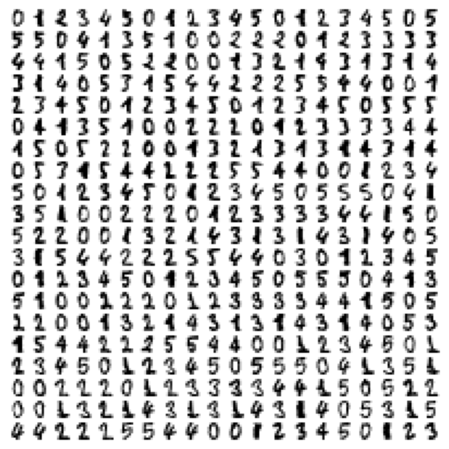

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

digits = datasets.load_digits(n_class=6)
# 这里只提取了0-5这6个数字
X, y = digits.data, digits.target
n_samples, n_features = X.shape
# print(X.shape)
'''显示原始数据'''
n = 20  # 每行20个数字，每列20个数字
img = np.zeros((10 * n, 10 * n))
for i in range(n):
    ix = 10 * i + 1
    for j in range(n):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n + j].reshape((8, 8))
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()




In [110]:
# X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  0.,  0.],
       [ 0.,  0.,  0., ...,  4.,  0.,  0.],
       [ 0.,  0.,  6., ...,  6.,  0.,  0.]])

Text(1, 2, 'A')

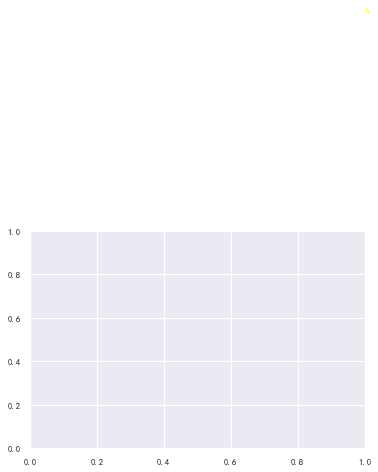

In [119]:
tsne = manifold.TSNE(n_components=2, random_state=64)
X_tsne = tsne.fit_transform(X)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
x_norm = (X_tsne - x_min) / (x_max - x_min)
# for i in range(x_norm.shape[0]):
#     plt.text(x_norm)
plt.text(1, 2, 'A', color=plt.cm.Set1(y[i]))